In [1]:
import pandas as pd
from datetime import datetime

# Extração dos dados

In [2]:
# link do dataset : https://www.kaggle.com/datasets/vijayuv/onlineretail/code

In [3]:
# Carregar o dataset CSV
df = pd.read_csv("online_retail.csv", encoding='ISO-8859-1')

In [4]:
# Remover valores nulos que podem afetar a análise
df = df.dropna(subset=["CustomerID", "Description", "Country"])

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


# Transformações

In [7]:
# Renomear a coluna 'Country' para 'Pais'
df.rename(columns={'Country': 'Pais'}, inplace=True)

In [8]:
# Criando coluna anoMês
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['anoMes'] = df['InvoiceDate'].map(lambda date : 100*date.year + date.month)

In [9]:
# Criando a Tabela Dim_Produto
dim_produto = df[['StockCode', 'Description']].drop_duplicates().copy()
dim_produto['ID_Produto'] = range(1, len(dim_produto) + 1)

In [10]:
# Criando a Tabela Dim_Cliente
dim_cliente = df[['CustomerID', 'Pais']].drop_duplicates().copy()
dim_cliente['ID_Cliente'] = range(1, len(dim_cliente) + 1)

In [11]:
# Criando a Tabela Dim_Pais
dim_pais = df[['Pais']].drop_duplicates().copy()
dim_pais['ID_Pais'] = range(1, len(dim_pais) + 1)

In [12]:
# Criando a Tabela Dim_Tempo
dim_tempo = pd.DataFrame({
    'ID_Tempo': range(1, len(df['InvoiceDate'].dt.date.unique()) + 1),
    'Data': df['InvoiceDate'].dt.date.unique(),
})
dim_tempo['Dia'] = dim_tempo['Data'].apply(lambda x: x.day)
dim_tempo['Mês'] = dim_tempo['Data'].apply(lambda x: x.month)
dim_tempo['Ano'] = dim_tempo['Data'].apply(lambda x: x.year)
dim_tempo['Dia_Semana'] = dim_tempo['Data'].apply(lambda x: x.strftime('%A'))
dim_tempo['Trimestre'] = dim_tempo['Mês'].apply(lambda x: (x - 1) // 3 + 1)
dim_tempo['anoMes'] = df['anoMes']

In [13]:
# Criando a Tabela Fato_Vendas
# Merge das dimensões para obter os IDs nas transações
df_fato = df.merge(dim_produto, on='StockCode', indicator='_produto')\
            .merge(dim_cliente, on='CustomerID')

In [14]:
# Renomear a coluna 'Pais_x' para 'Pais'
df_fato.rename(columns={'Pais_x': 'Pais'}, inplace=True)

In [15]:
df_fato = df_fato.merge(dim_pais, on='Pais')

In [16]:
# Mapeando a data para a tabela de tempo
df_fato['Data'] = df_fato['InvoiceDate'].dt.date
df_fato = df_fato.merge(dim_tempo, on='Data')

In [17]:
# Renomear a coluna 'Pais_x' para 'Pais'
df_fato.rename(columns={'anoMes_x': 'anoMes'}, inplace=True)

In [77]:
# Criando a tabela fato com as métricas de vendas
fato_vendas = df_fato[['InvoiceNo', 'ID_Produto', 'ID_Cliente', 'ID_Tempo', 'ID_Pais', 'Quantity', 'UnitPrice', 'anoMes']].copy()
fato_vendas['Valor_Venda'] = fato_vendas['Quantity'] * fato_vendas['UnitPrice']
fato_vendas['ID_Venda'] = range(1, len(fato_vendas) + 1)

# Carregamento

In [19]:
# Salvando as tabelas em CSV ou inserindo em um banco de dados, se necessário
dim_produto.to_csv("dim_produto.csv", index=False)
dim_cliente.to_csv("dim_cliente.csv", index=False)
dim_pais.to_csv("dim_pais.csv", index=False)
dim_tempo.to_csv("dim_tempo.csv", index=False)
fato_vendas.to_csv("fato_vendas.csv", index=False)

# Análises em SQL

In [20]:
import sqlite3 as sql

In [74]:
# Criar uma conexão com um banco de dados SQLite em memória
conn = sql.connect(':memory:')

In [78]:
fato_vendas.to_sql('fato_vendas', conn, index=False, if_exists='replace')
dim_pais.to_sql('dim_pais', conn, index=False, if_exists='replace')
dim_produto.to_sql('dim_produto', conn, index=False, if_exists='replace')
dim_cliente.to_sql('dim_cliente', conn, index=False, if_exists='replace')
dim_tempo.to_sql('dim_tempo', conn, index=False, if_exists='replace')

305

## Análise de Receita por Produto

Quais são os produtos mais vendidos?

In [23]:
query = '''
SELECT p.Description, COUNT(f.ID_Produto) AS Total_Vendido
FROM fato_vendas f
JOIN dim_produto p ON f.ID_Produto = p.ID_Produto
GROUP BY p.Description
ORDER BY Total_Vendido DESC
LIMIT 10
'''

# Executar a consulta SQL
df_produtos_mais_vendidos = pd.read_sql_query(query, conn)

# Exibir o resultado
print(df_produtos_mais_vendidos)

                          Description  Total_Vendido
0  WHITE HANGING HEART T-LIGHT HOLDER           2080
1  CREAM HANGING HEART T-LIGHT HOLDER           2080
2            REGENCY CAKESTAND 3 TIER           1911
3             JUMBO BAG RED RETROSPOT           1664
4       ASSORTED COLOUR BIRD ORNAMENT           1421
5                       PARTY BUNTING           1419
6                LUNCH BAG RED SPOTTY           1363
7             LUNCH BAG RED RETROSPOT           1363
8   SET OF 3 CAKE TINS PANTRY DESIGN            1234
9                             POSTAGE           1222


Qual a receita gerada por produto ao longo do tempo?

In [24]:
query = '''
SELECT p.Description, f.anoMes, SUM(f.Valor_Venda) AS Receita_Total
FROM fato_vendas f
JOIN dim_produto p ON f.ID_Produto = p.ID_Produto
where p.Description like 'REGENCY CAKESTAND 3 TIER'
GROUP BY p.Description, anoMes
ORDER BY anoMes, Receita_Total DESC;
'''

# Executar a consulta SQL
df_maior_receita = pd.read_sql_query(query, conn)

# Exibir o resultado
print(df_maior_receita)

                 Description  anoMes  Receita_Total
0   REGENCY CAKESTAND 3 TIER  201012       16835.10
1   REGENCY CAKESTAND 3 TIER  201101        9707.40
2   REGENCY CAKESTAND 3 TIER  201102        9016.20
3   REGENCY CAKESTAND 3 TIER  201103       13256.00
4   REGENCY CAKESTAND 3 TIER  201104       12214.95
5   REGENCY CAKESTAND 3 TIER  201105       11074.90
6   REGENCY CAKESTAND 3 TIER  201106        7950.10
7   REGENCY CAKESTAND 3 TIER  201107       12015.45
8   REGENCY CAKESTAND 3 TIER  201108        6844.95
9   REGENCY CAKESTAND 3 TIER  201109        8265.63
10  REGENCY CAKESTAND 3 TIER  201110       11376.75
11  REGENCY CAKESTAND 3 TIER  201111       10063.14
12  REGENCY CAKESTAND 3 TIER  201112        4492.08


## Análise de Cliente

Quem são os clientes que mais gastam?

In [25]:
query = '''
SELECT c.CustomerID, SUM(f.Valor_Venda) AS Total_Gasto
FROM fato_vendas f
JOIN dim_cliente c ON f.ID_Cliente = c.ID_Cliente
GROUP BY c.CustomerID
ORDER BY Total_Gasto DESC
LIMIT 10;
'''

# Executar a consulta SQL
df_mais_gastam = pd.read_sql_query(query, conn)

# Exibir o resultado
print(df_mais_gastam)

   CustomerID  Total_Gasto
0     14646.0    317530.25
1     18102.0    283459.48
2     17450.0    208469.05
3     14911.0    147311.80
4     12415.0    145163.21
5     14156.0    133138.02
6     17511.0    109608.40
7     16684.0     73148.60
8     13694.0     67493.23
9     15311.0     66170.07


Qual a frequência de compras de clientes específicos ao longo do tempo?

In [26]:
query = '''
SELECT c.CustomerID, COUNT(f.ID_Cliente) AS Frequencia_Compras, f.anoMes
FROM fato_vendas f
JOIN dim_cliente c ON f.ID_Cliente = c.ID_Cliente
GROUP BY c.CustomerID, anoMes
ORDER BY Frequencia_Compras, anoMes DESC;
'''

# Executar a consulta SQL
df_frequencia = pd.read_sql_query(query, conn)

# Exibir o resultado
print(df_frequencia)

       CustomerID  Frequencia_Compras  anoMes
0         12375.0                   1  201112
1         12709.0                   1  201112
2         12785.0                   1  201112
3         12901.0                   1  201112
4         12957.0                   1  201112
...           ...                 ...     ...
13670     17841.0                1118  201110
13671     17841.0                1571  201111
13672     12748.0                1848  201111
13673     14096.0                1918  201110
13674     14096.0                2035  201111

[13675 rows x 3 columns]


## Análise Temporal

Quais são os meses ou trimestres com maior volume de vendas?

Meses:

In [27]:
query = '''
SELECT anoMes, SUM(f.Valor_Venda) AS Total_Vendas
FROM fato_vendas f
GROUP BY anoMes
ORDER BY Total_Vendas DESC;
'''

# Executar a consulta SQL
df_volume_vendas_temporal_mensal = pd.read_sql_query(query, conn)

# Exibir o resultado
print(df_volume_vendas_temporal_mensal)

    anoMes  Total_Vendas
0   201111   1295896.080
1   201110   1129181.770
2   201109   1056805.742
3   201105    749476.780
4   201106    737398.800
5   201108    713122.800
6   201107    674296.191
7   201103    625765.370
8   201012    605688.600
9   201101    533047.460
10  201102    475901.580
11  201104    464461.871
12  201112    388331.320


Trimestres:

In [28]:
query = '''
SELECT 
    t.Ano || '-Q' || t.Trimestre AS Ano_Trimestre,
    SUM(f.Valor_Venda) AS Total_Vendas
FROM fato_vendas f
JOIN dim_tempo t ON f.ID_Tempo = t.ID_Tempo
GROUP BY Ano_Trimestre
ORDER BY Total_Vendas DESC;
'''

# Executar a consulta SQL e armazenar o resultado em um DataFrame
df_volume_vendas_temporal_trimestral = pd.read_sql_query(query, conn)

# Exibir o resultado
print(df_volume_vendas_temporal_trimestral)

  Ano_Trimestre  Total_Vendas
0       2011-Q4   2813409.170
1       2011-Q3   2444224.733
2       2011-Q2   1951337.451
3       2011-Q1   1634714.410
4       2010-Q4    605688.600


## Análise Geográfica

Quais países geram mais receita?

In [29]:
query = '''
SELECT p.Pais, SUM(f.Valor_Venda) AS Receita_Total
FROM fato_vendas f
JOIN dim_pais p ON f.ID_Pais = p.ID_Pais
GROUP BY p.Pais
ORDER BY Receita_Total DESC;
'''

# Executar a consulta SQL
df_paises_receita = pd.read_sql_query(query, conn)

# Exibir o resultado
print(df_paises_receita)

                    Pais  Receita_Total
0         United Kingdom    7688393.064
1            Netherlands     323280.190
2                   EIRE     285110.340
3                Germany     244656.400
4                 France     217368.070
5              Australia     166382.090
6                  Spain      70475.260
7            Switzerland      64169.640
8                Belgium      50339.980
9                 Sweden      41929.350
10                Norway      39667.830
11                 Japan      37814.190
12              Portugal      32912.170
13               Finland      28004.680
14               Denmark      26404.290
15       Channel Islands      22483.250
16                Cyprus      20816.780
17                 Italy      18652.570
18               Austria      12112.720
19             Singapore      10486.650
20                Israel       8292.560
21                Poland       7708.170
22                Greece       5062.480
23               Iceland       4452.220


Relação entre o país do cliente e os produtos

In [30]:
query = '''
SELECT p.Pais, pr.Description, SUM(f.Valor_Venda) AS Receita_Total
FROM fato_vendas f
JOIN dim_pais p ON f.ID_Pais = p.ID_Pais
JOIN dim_produto pr ON f.ID_Produto = pr.ID_Produto
GROUP BY p.Pais, pr.Description
ORDER BY Receita_Total DESC;
'''

# Executar a consulta SQL
df_relacao_paises_produtos = pd.read_sql_query(query, conn)

# Exibir o resultado
print(df_relacao_paises_produtos)

                 Pais                         Description  Receita_Total
0      United Kingdom            REGENCY CAKESTAND 3 TIER      103122.85
1      United Kingdom  CREAM HANGING HEART T-LIGHT HOLDER       88469.30
2      United Kingdom  WHITE HANGING HEART T-LIGHT HOLDER       88469.30
3      United Kingdom             JUMBO BAG RED RETROSPOT       75416.67
4      United Kingdom                       PARTY BUNTING       61952.58
...               ...                                 ...            ...
20751            EIRE                              Manual       -1121.18
20752           Spain                              Manual       -2842.62
20753  United Kingdom                            Discount       -5028.98
20754  United Kingdom                     CRUK Commission       -7933.43
20755  United Kingdom                              Manual      -54859.41

[20756 rows x 3 columns]


Número de ordens canceladas

In [31]:
query = '''
SELECT COUNT(*) AS Ordens_Canceladas
FROM fato_vendas f
where InvoiceNo LIKE 'C%'
'''

# Executar a consulta SQL
df_qnt_cancelados = pd.read_sql_query(query, conn)

# Exibir o resultado
print(df_qnt_cancelados)

   Ordens_Canceladas
0              10082


# Análises em gráficos

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

Produtos Mais Vendidos

In [34]:
def plot_produtos_mais_vendidos(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Total_Vendido', y='Description', data=df, palette='coolwarm')
    plt.title('Produtos Mais Vendidos')
    plt.xlabel('Quantidade Vendida')
    plt.ylabel('Produto')
    plt.show()


C:\Users\jonat\AppData\Local\Temp\ipykernel_10464\954620148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Vendido', y='Description', data=df, palette='coolwarm')


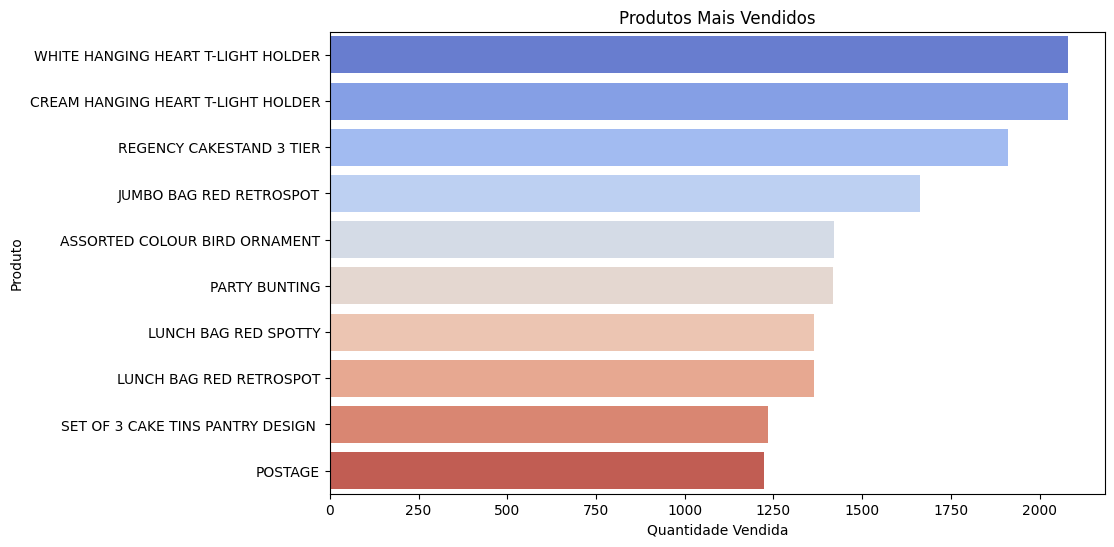

In [35]:
plot_produtos_mais_vendidos(df_produtos_mais_vendidos)

Maior receita por produto, exemplo: "REGENCY CAKESTAND 3 TIER"

In [36]:
def plot_maior_receita(df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='anoMes', y='Receita_Total', hue='Description', data=df, palette='tab10')
    plt.title('Receita Produto ao Longo do Tempo')
    plt.xlabel('anoMes')
    plt.ylabel('Receita_Total')
    plt.legend(title='Description')
    plt.show()

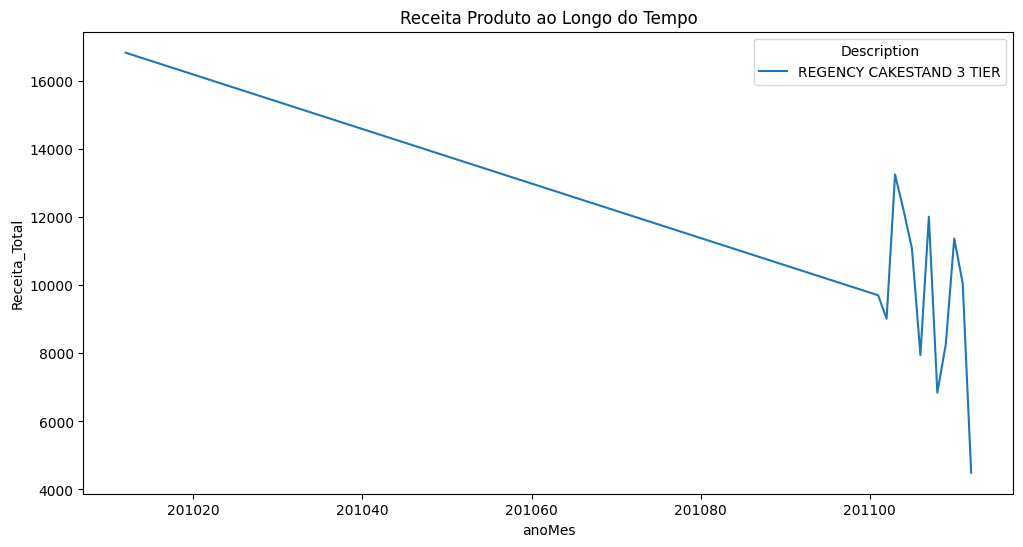

In [37]:
plot_maior_receita(df_maior_receita)

Clientes que Mais Gastam

In [38]:
def plot_clientes_que_mais_gastam(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='CustomerID', y='Total_Gasto', data=df, palette='coolwarm')
    plt.title('Clientes que Mais Gastam')
    plt.xlabel('Cliente ID')
    plt.ylabel('Total_Gasto')
    plt.show()

C:\Users\jonat\AppData\Local\Temp\ipykernel_10464\552107118.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CustomerID', y='Total_Gasto', data=df, palette='coolwarm')


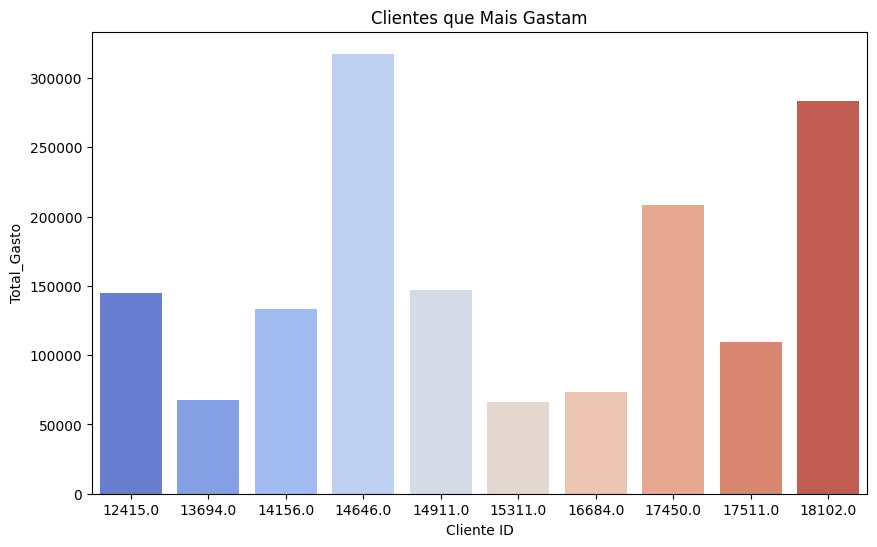

In [39]:
plot_clientes_que_mais_gastam(df_mais_gastam)

Frequência de Compras de Clientes ao Longo do Tempo

In [40]:
def plot_frequencia_compras_clientes(df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='anoMes', y='Frequencia_Compras', hue='CustomerID', data=df, palette='Set2')
    plt.title('Frequência de Compras de Clientes ao Longo do Tempo')
    plt.xlabel('Data')
    plt.ylabel('Frequência de Compras')
    plt.legend(title='Cliente ID')
    plt.show()


In [41]:
df_frequencia= df_frequencia.query(''' CustomerID == 17841.0 ''')

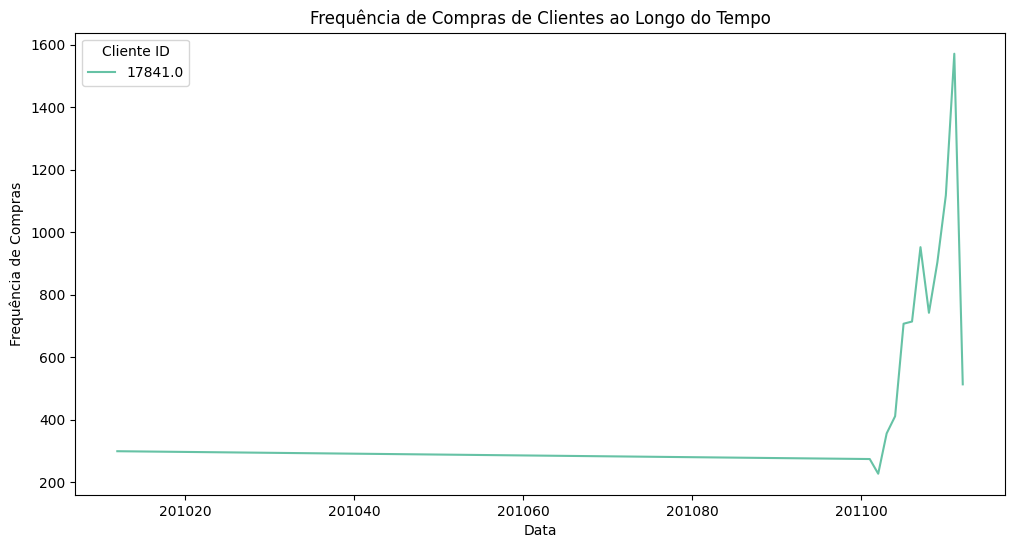

In [42]:
# Exemplo cliente 17841.0
plot_frequencia_compras_clientes(df_frequencia)

Volume de vendas por Mês

In [43]:
def plot_volume_vendas_temporal(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='anoMes', y='Total_Vendas', data=df, palette='crest')
    plt.title('Volume de Vendas por Mês')
    plt.xlabel('Mês')
    plt.ylabel('Volume de Vendas')
    plt.show()

C:\Users\jonat\AppData\Local\Temp\ipykernel_10464\1014554602.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='anoMes', y='Total_Vendas', data=df, palette='crest')


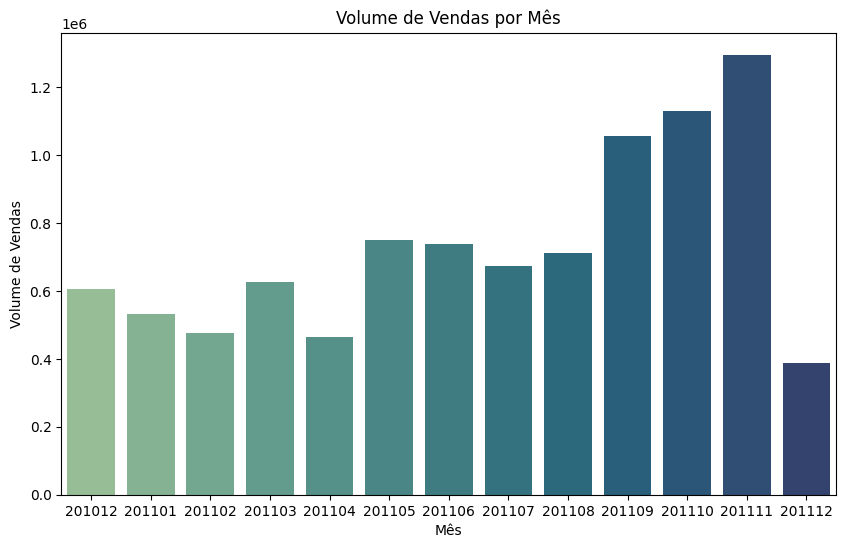

In [44]:
plot_volume_vendas_temporal(df_volume_vendas_temporal_mensal)

Volume de Vendas por Trimestre

In [45]:
def plot_volume_vendas_trimestral(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Ano_Trimestre', y='Total_Vendas', data=df, palette='crest')
    plt.title('Volume de Vendas por Trimestre')
    plt.xlabel('Trimestre')
    plt.ylabel('Volume de Vendas')
    plt.show()

C:\Users\jonat\AppData\Local\Temp\ipykernel_10464\1271378217.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ano_Trimestre', y='Total_Vendas', data=df, palette='crest')


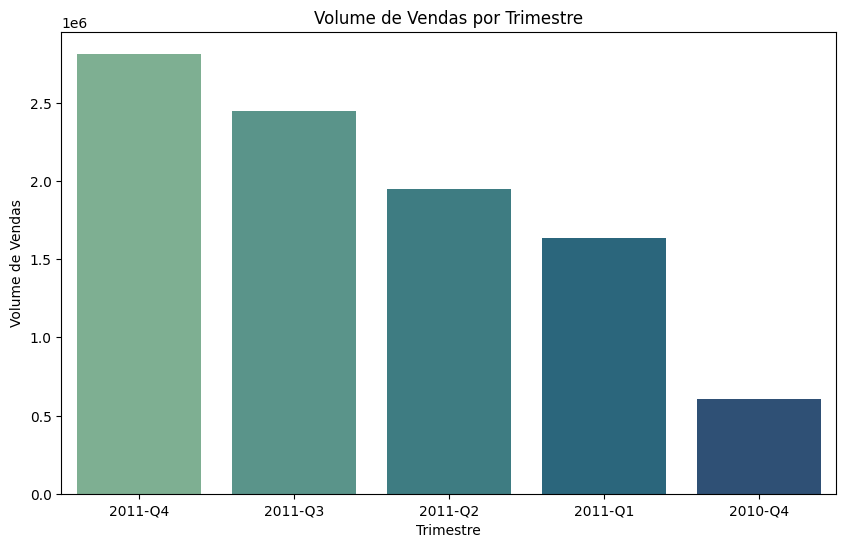

In [46]:
plot_volume_vendas_trimestral(df_volume_vendas_temporal_trimestral)

Receita por País

In [47]:
def plot_receita_por_pais(df):
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Receita_Total', y='Pais', data=df, palette='magma')
    plt.title('Receita por País')
    plt.xlabel('Receita')
    plt.ylabel('País')
    plt.show()

C:\Users\jonat\AppData\Local\Temp\ipykernel_10464\1153317239.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Receita_Total', y='Pais', data=df, palette='magma')


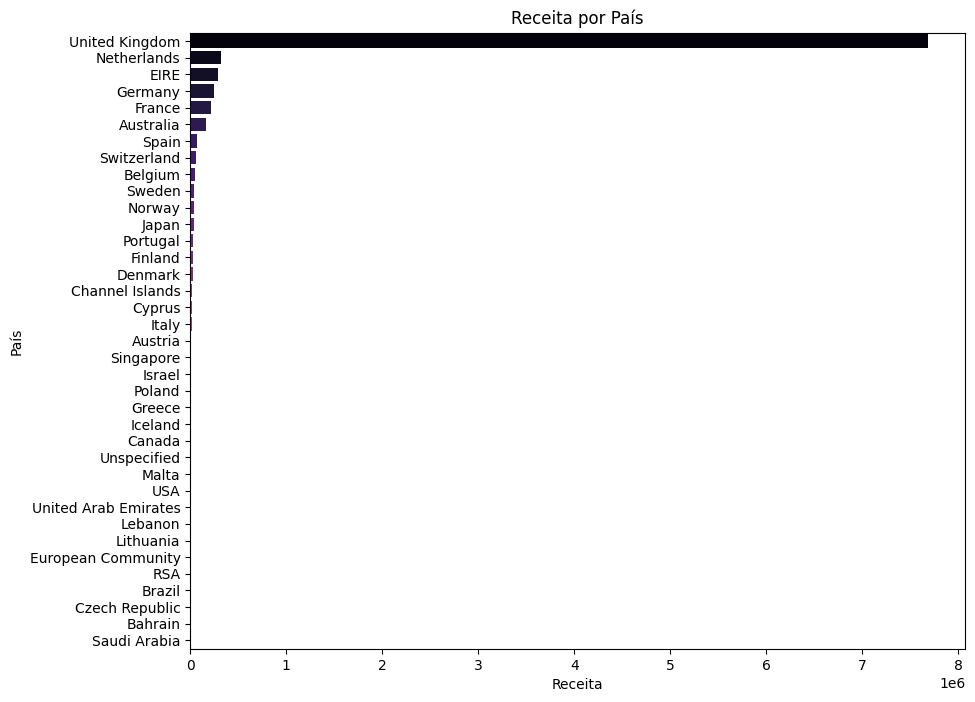

In [48]:
plot_receita_por_pais(df_paises_receita)

Quantidade de cancelados

In [49]:
def plot_ordens_canceladas(df_coluna):
    # Extrair o valor da primeira célula da coluna
    ordens_canceladas = df_coluna.iloc[0]
    
    # Criar a visualização
    plt.figure(figsize=(6, 4))
    plt.text(0.5, 0.5, f'{ordens_canceladas} Ordens', fontsize=50, ha='center', va='center')
    plt.axis('off')  # Remove os eixos
    plt.title("Total de Ordens Canceladas")
    plt.show()

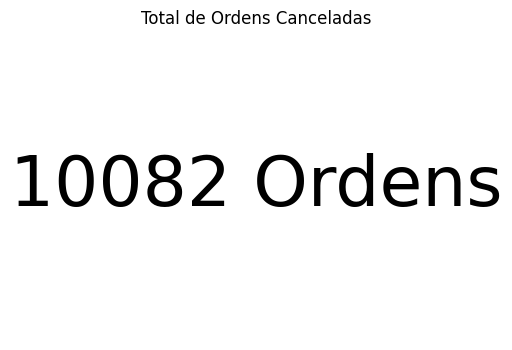

In [50]:
plot_ordens_canceladas(df_qnt_cancelados['Ordens_Canceladas'])

In [65]:
import geopandas as gpd

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [58]:
df_paises_receita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pais           37 non-null     object 
 1   Receita_Total  37 non-null     float64
dtypes: float64(1), object(1)
memory usage: 724.0+ bytes


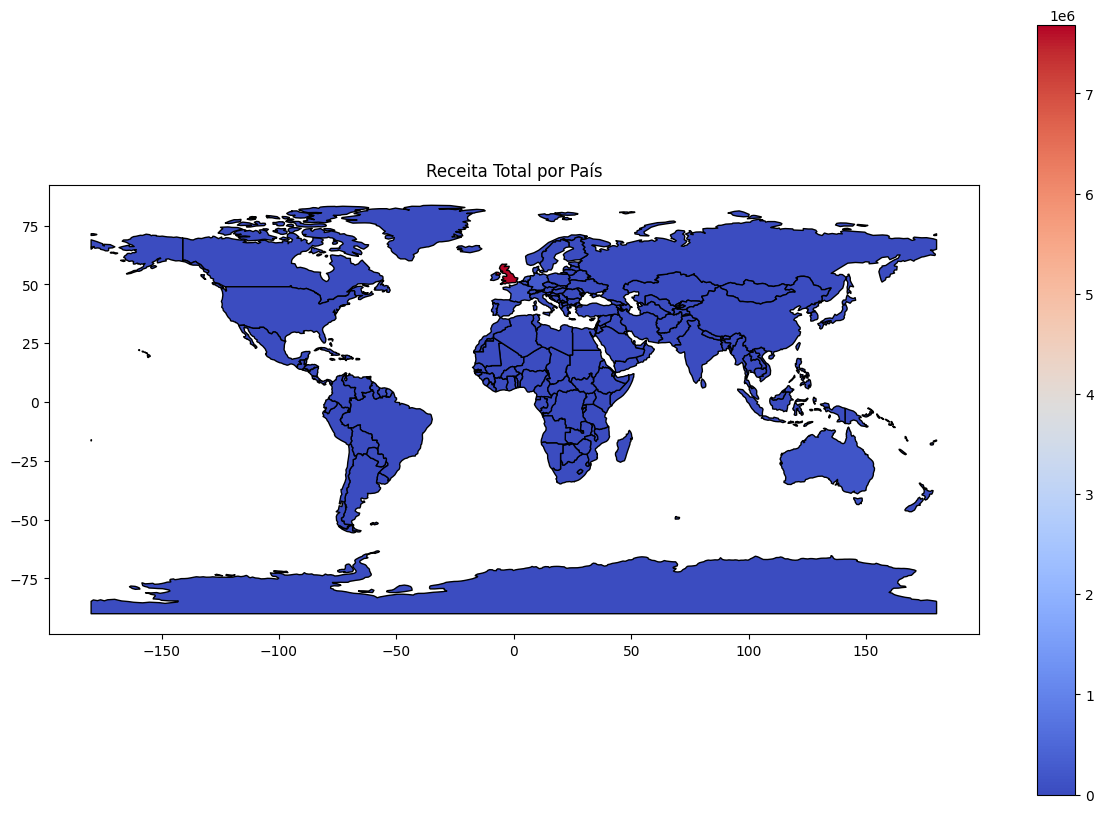

In [72]:
# Carregar o shapefile baixado manualmente (substitua pelo caminho do arquivo extraído)
world = gpd.read_file("maps/ne_110m_admin_0_countries.shp")

# Renomear a coluna 'name' para 'Pais' para fazer a junção
world = world.rename(columns={'NAME': 'Pais'})  # 'NAME' é a coluna padrão para nomes de países no shapefile

# Fazer o merge entre o mapa base e os dados de receita
world_receita = world.merge(df_paises_receita, on='Pais', how='left')

# Substituir valores NaN por 0 na coluna 'Receita_Total' (caso algum país não tenha dados de receita)
world_receita['Receita_Total'] = world_receita['Receita_Total'].fillna(0)

# Plotar o mapa com a receita por país
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_receita.plot(column='Receita_Total', cmap='YlOrRd', legend=True, ax=ax, edgecolor='black')
plt.title("Receita Total por País")
plt.show()

Análise sem UK por ser um "outlier" nessa visão

In [81]:
query = '''
SELECT p.Pais, SUM(f.Valor_Venda) AS Receita_Total
FROM fato_vendas f
JOIN dim_pais p ON f.ID_Pais = p.ID_Pais
WHERE p.Pais != 'United Kingdom'
GROUP BY p.Pais
ORDER BY Receita_Total DESC;
'''

# Executar a consulta SQL
df_paises_receita_sem_uk = pd.read_sql_query(query, conn)

In [83]:
df_paises_receita_sem_uk.head()

,Pais,Receita_Total
0,Netherlands,323280.19
1,EIRE,285110.34
2,Germany,244656.40
3,France,217368.07
4,Australia,166382.09


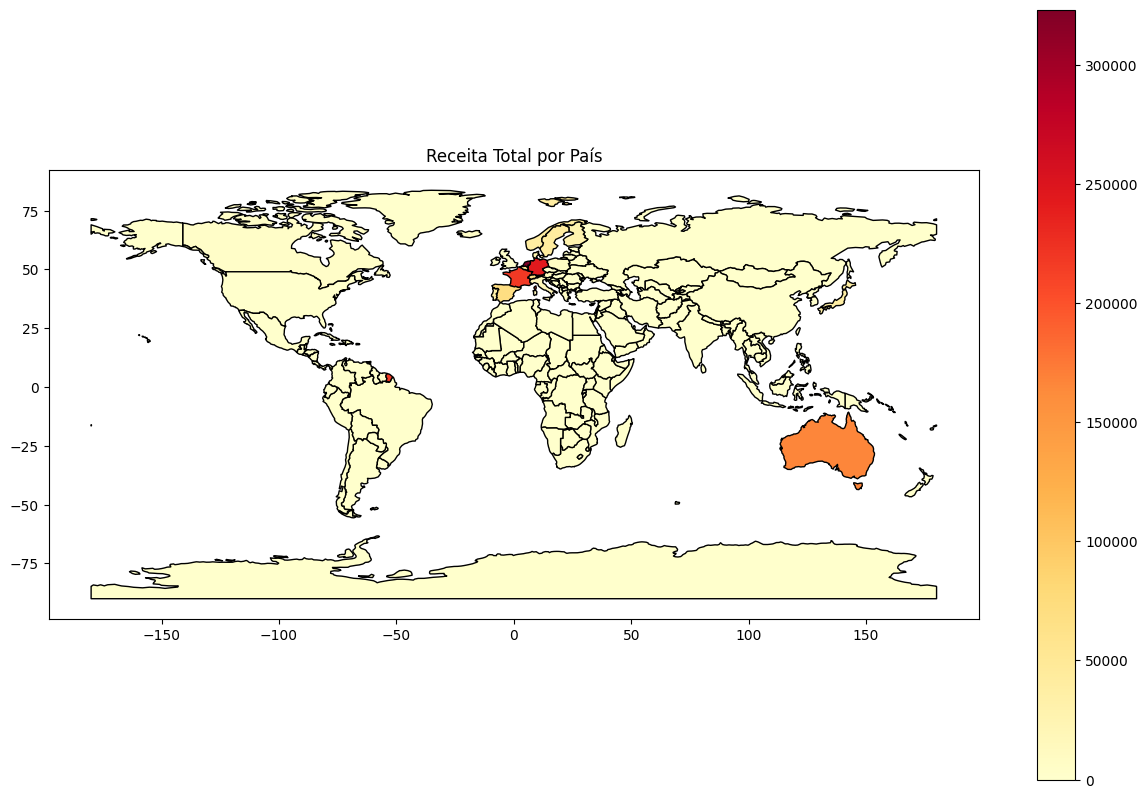

In [82]:
# Carregar o shapefile baixado manualmente (substitua pelo caminho do arquivo extraído)
world = gpd.read_file("maps/ne_110m_admin_0_countries.shp")

# Renomear a coluna 'name' para 'Pais' para fazer a junção
world = world.rename(columns={'NAME': 'Pais'})  # 'NAME' é a coluna padrão para nomes de países no shapefile

# Fazer o merge entre o mapa base e os dados de receita
world_receita = world.merge(df_paises_receita_sem_uk, on='Pais', how='left')

# Substituir valores NaN por 0 na coluna 'Receita_Total' (caso algum país não tenha dados de receita)
world_receita['Receita_Total'] = world_receita['Receita_Total'].fillna(0)

# Plotar o mapa com a receita por país
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_receita.plot(column='Receita_Total', cmap='YlOrRd', legend=True, ax=ax, edgecolor='black')
plt.title("Receita Total por País")
plt.show()

In [ ]:
conn.close()